In [1]:
import torch

torch.__version__
torch.cuda.is_available()

if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(1)}")
else:
    print("GPU is not available")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(f"Using device: {device}")

GPU is available: NVIDIA GeForce RTX 3090
Using device: cuda
Using device: cuda


In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

class LungDataset(Dataset):
    def __init__(self,image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = sorted(os.listdir(image_dir))

        self.transform = T.Compose([
            T.Resize((256, 256)),
            T.ToTensor(),
        ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        mask_name = img_name.replace(".jpg", "_mask.png")
        
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        image = self.transform(image)
        mask = self.transform(mask)

        return image, mask
    



    


In [3]:
from torch.utils.data import DataLoader

dataset = LungDataset("../dataset/Chest-X-Ray/Chest-X-Ray/image","../dataset/Chest-X-Ray/Chest-X-Ray/mask")
loader = DataLoader(dataset, batch_size = 4, shuffle= True)

for images, masks in loader:
    print(images.shape)
    print(masks.shape)
    break


torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])


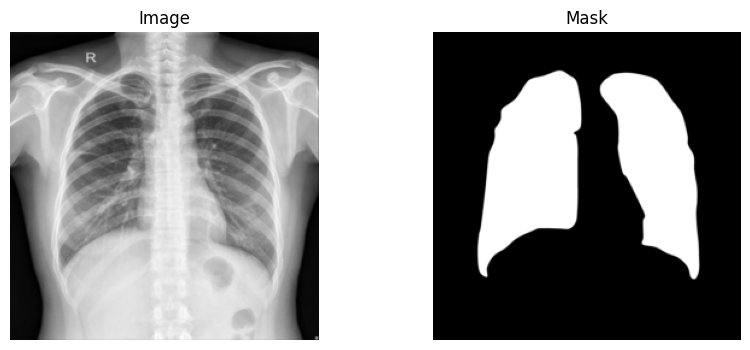

In [4]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size = 1, shuffle= True)

image, mask = next(iter(loader))
image = image.squeeze().numpy()
mask = mask.squeeze().numpy()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 인코더 (Down)
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        # 디코더 (Up)
        self.up1 = self.up_block(256, 128)
        self.up2 = self.up_block(128, 64)

        # 최종 출력 (1채널 마스크)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        # 인코딩
        x1 = self.enc1(x)
        x2 = self.enc2(F.max_pool2d(x1, 2))
        x3 = self.enc3(F.max_pool2d(x2, 2))

        # 디코딩
        x = self.up1(x3)
        x = self.up2(x)

        # 출력
        x = self.final_conv(x)
        x = torch.sigmoid(x)  # binary mask니까 sigmoid
        return x


In [6]:
model = UNet()
x = torch.randn(1, 1, 256, 256)  # (batch=1, channel=1, H=256, W=256)
output = model(x)

print("입력:", x.shape)
print("출력:", output.shape)


입력: torch.Size([1, 1, 256, 256])
출력: torch.Size([1, 1, 256, 256])


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
model = UNet().to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [20]:
from torch.utils.data import DataLoader

dataset = LungDataset("../dataset/Chest-X-Ray/Chest-X-Ray/image","../dataset/Chest-X-Ray/Chest-X-Ray/mask")
loader = DataLoader(dataset, batch_size=4, shuffle=True)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # 학습 모드
    epoch_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)  # U-Net 결과
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}")


[Epoch 1] Loss: 0.4017
[Epoch 2] Loss: 0.2122
[Epoch 3] Loss: 0.1612
[Epoch 4] Loss: 0.1270
[Epoch 5] Loss: 0.1026


In [9]:
import mlflow
import mlflow.pytorch


/home/kmj388/micromamba/envs/iris-mlops/lib/python3.10/site-packages/mlflow/utils/requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [10]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("unet-experiment")


<Experiment: artifact_location='s3://mlflow-artifacts/1', creation_time=1754025710977, experiment_id='1', last_update_time=1754025710977, lifecycle_stage='active', name='unet-experiment', tags={}>

In [11]:
with mlflow.start_run():
    # 🧾 파라미터 기록
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("batch_size", 1)
    mlflow.log_param("lr", 0.001)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}")
        mlflow.log_metric("loss", avg_loss, step=epoch)

    # ✅ 모델 저장
    mlflow.pytorch.log_model(model, "unet-model")

    # 🎨 예측 마스크 하나 저장해서 이미지로 기록해보기
    model.eval()
    sample_img, _ = next(iter(loader))
    sample_img = sample_img.to(device)
    with torch.no_grad():
        pred_mask = model(sample_img)

    # 첫 번째 마스크만 시각화 저장
    import matplotlib.pyplot as plt
    import numpy as np

    pred_np = pred_mask[0][0].cpu().numpy()
    os.makedirs("outputs", exist_ok=True)
    plt.imsave("outputs/sample_pred_mask.png", pred_np, cmap='gray')
    mlflow.log_artifact("outputs/sample_pred_mask.png")

NameError: name 'num_epochs' is not defined

In [12]:
os.environ['AWS_ACCESS_KEY_ID'] = 'mlflow'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'mlflowpass' 
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:30001'

print("환경 변수 설정 완료!")
print(f"AWS_ACCESS_KEY_ID: {os.environ.get('AWS_ACCESS_KEY_ID')}")
print(f"MLFLOW_S3_ENDPOINT_URL: {os.environ.get('MLFLOW_S3_ENDPOINT_URL')}")

환경 변수 설정 완료!
AWS_ACCESS_KEY_ID: mlflow
MLFLOW_S3_ENDPOINT_URL: http://localhost:30001


In [13]:
mlflow.pytorch.log_model(model, "unet-model")

2025/08/01 06:16:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/01 06:16:44 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-02-29; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'mathmodule'}


In [1]:
import segmentation_models_pytorch as smp

# U-Net with ResNet34 encoder pretrained on ImageNet
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",  # 사전학습 사용
    in_channels=1,  # 흑백 X-ray
    classes=1,      # binary segmentation
    activation=None
)


/home/kmj388/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class LungSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [4]:
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [10]:
import os
import cv2
import torch
import numpy as np
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# -------------------- 설정 --------------------
IMAGE_DIR = "Chest-X-Ray/image"
MASK_DIR = "Chest-X-Ray/mask"
BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 5
ENCODER = "resnet34"       # ← pretrained ImageNet
ENCODER_WEIGHTS = "imagenet"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------- 데이터셋 --------------------
class LungSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])  # 같은 이름이라고 가정

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, (mask.permute(2, 0, 1).float() / 255.0)

# -------------------- 트랜스폼 --------------------
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

# -------------------- 데이터로더 --------------------
train_dataset = LungSegmentationDataset(IMAGE_DIR, MASK_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# -------------------- 모델 --------------------
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=1,
    classes=1,
).to(DEVICE)

# -------------------- 학습 준비 --------------------
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# -------------------- 학습 루프 --------------------
model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

# -------------------- 저장 --------------------
torch.save(model.state_dict(), "unet_pretrained.pth")
print("✅ 모델 저장 완료: unet_pretrained.pth")


Epoch 1/5: 100%|██████████| 11/11 [01:24<00:00,  7.71s/it]


Epoch 1 Loss: 7.3484


Epoch 2/5: 100%|██████████| 11/11 [01:26<00:00,  7.85s/it]


Epoch 2 Loss: 5.0728


Epoch 3/5: 100%|██████████| 11/11 [01:26<00:00,  7.89s/it]


Epoch 3 Loss: 4.3265


Epoch 4/5: 100%|██████████| 11/11 [01:26<00:00,  7.89s/it]


Epoch 4 Loss: 3.8478


Epoch 5/5: 100%|██████████| 11/11 [01:26<00:00,  7.87s/it]

Epoch 5 Loss: 3.4627
✅ 모델 저장 완료: unet_pretrained.pth


In [11]:
model.eval()












Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 테스트 이미지 경로
test_image_path = "../train-classifier/chest_xray/test/PNEUMONIA/person1_virus_9.jpeg"

# 동일한 transform 사용
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

# 이미지 전처리
image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
image = np.expand_dims(image, axis=-1)  # (H, W, 1)
aug = transform(image=image)
image_tensor = aug['image'].unsqueeze(0).to(DEVICE)  # [1, 1, 256, 256]


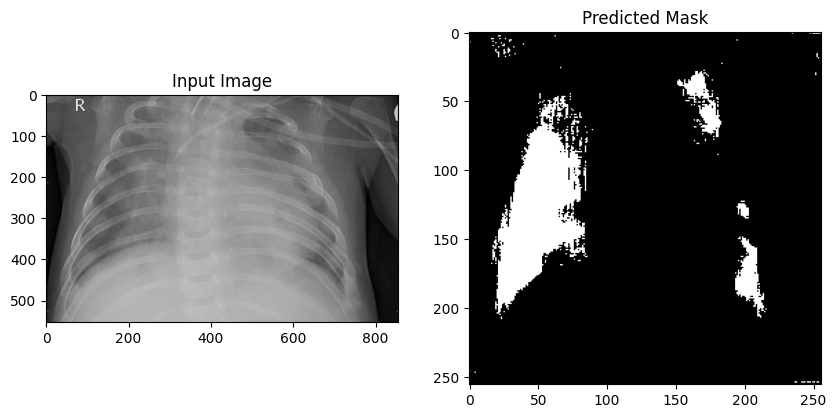

In [27]:
with torch.no_grad():
    pred = model(image_tensor)  # [1, 1, H, W]
    pred_mask = torch.sigmoid(pred)
    pred_mask = (pred_mask > 0.5).float()

# 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image.squeeze(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(pred_mask.squeeze().cpu(), cmap='gray')

plt.show()


In [34]:
#!/usr/bin/env python3
"""
UNet 모델 훈련 스크립트
폐 X-ray 이미지 세그멘테이션을 위한 UNet 모델을 훈련합니다.
"""

import os
import argparse
import time
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


class LungDataset(Dataset):
    """폐 X-ray 이미지와 마스크 데이터셋"""
    
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


class UNet(nn.Module):
    """UNet 모델 구조"""
    
    def __init__(self):
        super().__init__()
        
        def CBR(in_c, out_c):
            """Conv-BatchNorm-ReLU 블록"""
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )
        
        # Encoder
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = CBR(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder path with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat([dec4, enc4], dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))

        return torch.sigmoid(self.conv_last(dec1))


def create_data_loaders(image_dir, mask_dir, batch_size, train_split=0.8, image_size=256):
    """데이터 로더 생성"""
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    
    dataset = LungDataset(image_dir, mask_dir, transform=transform)
    
    train_len = int(train_split * len(dataset))
    val_len = len(dataset) - train_len
    train_ds, val_ds = random_split(dataset, [train_len, val_len])
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
    
    print(f"📊 데이터셋 정보:")
    print(f"   - 전체 데이터: {len(dataset)}개")
    print(f"   - 훈련 데이터: {len(train_ds)}개")
    print(f"   - 검증 데이터: {len(val_ds)}개")
    print(f"   - 배치 크기: {batch_size}")
    
    return train_loader, val_loader


def validate_model(model, val_loader, loss_fn, device):
    """모델 검증"""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)


def train_model(model, train_loader, val_loader, loss_fn, optimizer, device, epochs, save_path):
    """모델 훈련"""
    print(f"🚀 훈련 시작 - {epochs}개 에포크")
    print(f"📱 디바이스: {device}")
    print("-" * 50)
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # 훈련 모드
        model.train()
        train_loss = 0.0
        epoch_start_time = time.time()
        
        for batch_idx, (imgs, masks) in enumerate(train_loader):
            imgs, masks = imgs.to(device), masks.to(device)
            
            # Forward pass
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # 진행률 출력 (매 10 배치마다)
            if (batch_idx + 1) % 10 == 0:
                print(f"   배치 [{batch_idx+1}/{len(train_loader)}] - 손실: {loss.item():.4f}")
        
        # 검증
        val_loss = validate_model(model, val_loader, loss_fn, device)
        
        # 에포크 시간 계산
        epoch_time = time.time() - epoch_start_time
        
        # 결과 출력
        avg_train_loss = train_loss / len(train_loader)
        print(f"📈 에포크 [{epoch+1}/{epochs}] ({epoch_time:.1f}초)")
        print(f"   - 훈련 손실: {avg_train_loss:.4f}")
        print(f"   - 검증 손실: {val_loss:.4f}")
        
        # 베스트 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"   ✅ 베스트 모델 저장됨!")
        
        print("-" * 50)
    
    print(f"🎉 훈련 완료!")
    print(f"💾 베스트 모델 저장 위치: {save_path}")
    print(f"🏆 최고 검증 손실: {best_val_loss:.4f}")


def main():
    parser = argparse.ArgumentParser(description='UNet 폐 세그멘테이션 모델 훈련')
    
    # 데이터 경로
    parser.add_argument('--image_dir', type=str,default="Chest-X-Ray/image",
                        help='이미지 디렉토리 경로')
    parser.add_argument('--mask_dir', type=str, default="Chest-X-Ray/mask",
                        help='마스크 디렉토리 경로')
    
    # 훈련 설정
    parser.add_argument('--epochs', type=int, default=50,
                        help='훈련 에포크 수 (기본값: 50)')
    parser.add_argument('--batch_size', type=int, default=8,
                        help='배치 크기 (기본값: 8)')
    parser.add_argument('--lr', type=float, default=1e-4,
                        help='학습률 (기본값: 1e-4)')
    parser.add_argument('--image_size', type=int, default=256,
                        help='이미지 크기 (기본값: 256)')
    parser.add_argument('--train_split', type=float, default=0.8,
                        help='훈련 데이터 비율 (기본값: 0.8)')
    
    # 저장 설정
    parser.add_argument('--save_path', type=str, default='unet_lung_segmentation.pth',
                        help='모델 저장 경로 (기본값: unet_lung_segmentation.pth)')
    
    args, _ = parser.parse_known_args()

    
    # GPU 사용 가능 여부 확인
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print("🔥 UNet 폐 세그멘테이션 모델 훈련")
    print("=" * 50)
    
    # 데이터 로더 생성
    train_loader, val_loader = create_data_loaders(
        args.image_dir, args.mask_dir, args.batch_size, 
        args.train_split, args.image_size
    )
    
    # 모델, 손실함수, 옵티마이저 설정
    model = UNet().to(device)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    
    print(f"🏗️  모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
    
    # 훈련 시작
    train_model(model, train_loader, val_loader, loss_fn, optimizer, 
                device, args.epochs, args.save_path)


if __name__ == "__main__":
    main() 

🔥 UNet 폐 세그멘테이션 모델 훈련
📊 데이터셋 정보:
   - 전체 데이터: 704개
   - 훈련 데이터: 563개
   - 검증 데이터: 141개
   - 배치 크기: 8
🏗️  모델 파라미터 수: 31,042,369
🚀 훈련 시작 - 50개 에포크
📱 디바이스: cuda
--------------------------------------------------
   배치 [10/71] - 손실: 0.3700
   배치 [20/71] - 손실: 0.2568
   배치 [30/71] - 손실: 0.2192
   배치 [40/71] - 손실: 0.1904
   배치 [50/71] - 손실: 0.1780
   배치 [60/71] - 손실: 0.1935


KeyboardInterrupt: 

In [35]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt


In [36]:
class LungDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [37]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def CBR(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat([dec4, enc4], dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))

        return torch.sigmoid(self.conv_last(dec1))


In [39]:
# 실제 경로로 바꿔주세요!
image_dir = "Chest-X-Ray/image"
mask_dir  = "Chest-X-Ray/mask"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = LungDataset(image_dir, mask_dir, transform=transform)

train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [41]:
epochs = 20

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"[{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")


[1/20] Loss: 0.3188
[2/20] Loss: 0.2163
[3/20] Loss: 0.1879
[4/20] Loss: 0.1686
[5/20] Loss: 0.1521
[6/20] Loss: 0.1374
[7/20] Loss: 0.1264
[8/20] Loss: 0.1175
[9/20] Loss: 0.1081
[10/20] Loss: 0.0998
[11/20] Loss: 0.0940
[12/20] Loss: 0.0902
[13/20] Loss: 0.0843
[14/20] Loss: 0.0795
[15/20] Loss: 0.0751
[16/20] Loss: 0.0720
[17/20] Loss: 0.0703
[18/20] Loss: 0.0807
[19/20] Loss: 0.0685
[20/20] Loss: 0.0647


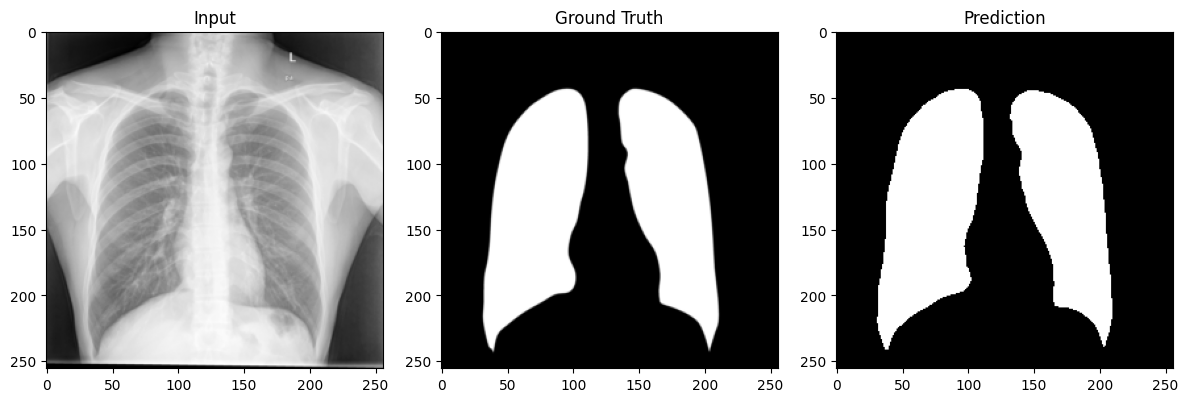

In [42]:
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))
    imgs, masks = imgs.to(device), masks.to(device)
    preds = model(imgs)

    img = imgs[0][0].cpu().numpy()
    pred = preds[0][0].cpu().numpy()
    mask = masks[0][0].cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img, cmap='gray'); plt.title("Input")
    plt.subplot(1, 3, 2); plt.imshow(mask, cmap='gray'); plt.title("Ground Truth")
    plt.subplot(1, 3, 3); plt.imshow(pred > 0.5, cmap='gray'); plt.title("Prediction")
    plt.tight_layout(); plt.show()


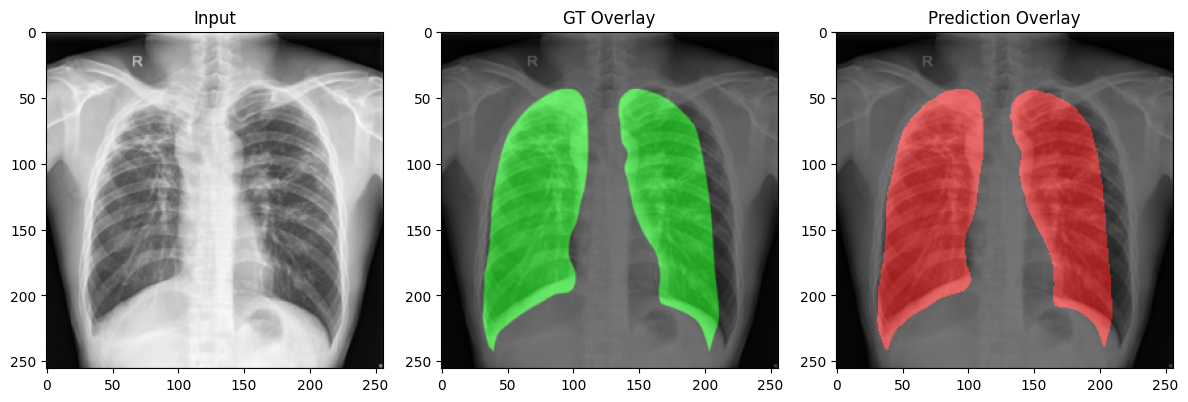

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_mask_on_image(image, mask, alpha=0.4, mask_color=(1, 0, 0)):
    """
    image: (H, W) numpy array, grayscale image [0,1]
    mask: (H, W) binary numpy array [0,1]
    alpha: blending ratio (0~1)
    mask_color: RGB tuple (default red)
    """
    image_rgb = np.stack([image]*3, axis=-1)  # (H, W, 3)
    color_mask = np.zeros_like(image_rgb)
    for c in range(3):
        color_mask[..., c] = mask * mask_color[c]
    blended = (1 - alpha) * image_rgb + alpha * color_mask
    return blended

# 예측 결과 한 샘플 가져오기
model.eval()
i = 7
with torch.no_grad():
    imgs, masks = next(iter(val_loader))
    imgs, masks = imgs.to(device), masks.to(device)
    preds = model(imgs)
    
    # 첫 번째 샘플
    img = imgs[i][0].cpu().numpy()
    pred_mask = (preds[0][0].cpu().numpy() > 0.5).astype(np.float32)
    gt_mask = masks[0][0].cpu().numpy()

# 오버레이 시각화
overlay_pred = overlay_mask_on_image(img, pred_mask, alpha=0.5, mask_color=(1, 0, 0))  # 빨간색
overlay_gt = overlay_mask_on_image(img, gt_mask, alpha=0.5, mask_color=(0, 1, 0))      # 초록색

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(img, cmap='gray'); plt.title("Input")
plt.subplot(1, 3, 2); plt.imshow(overlay_gt); plt.title("GT Overlay")
plt.subplot(1, 3, 3); plt.imshow(overlay_pred); plt.title("Prediction Overlay")
plt.tight_layout(); plt.show()


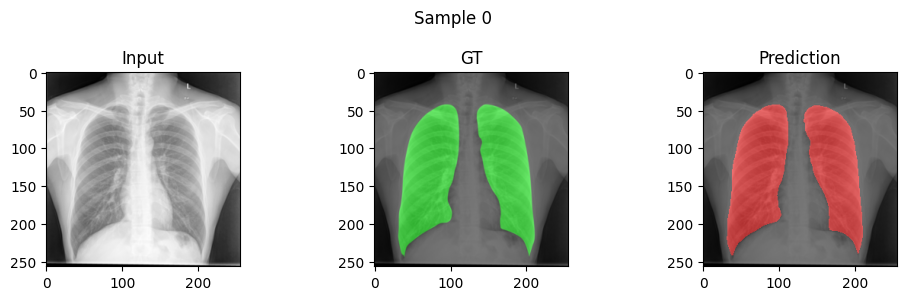

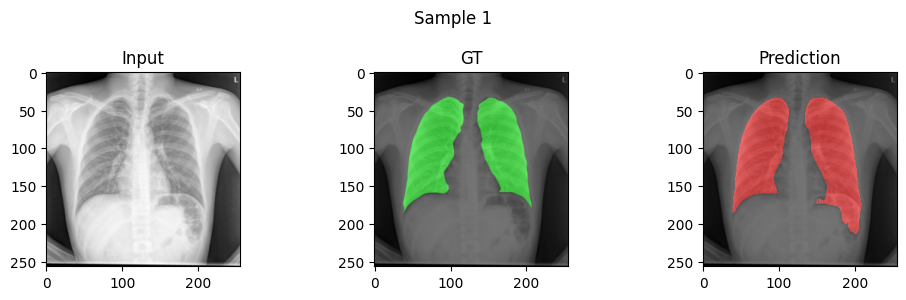

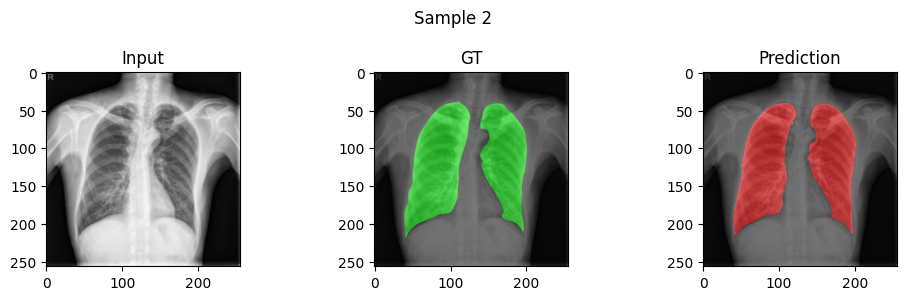

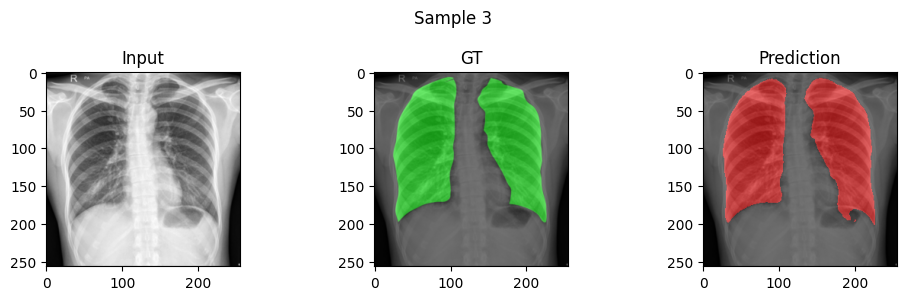

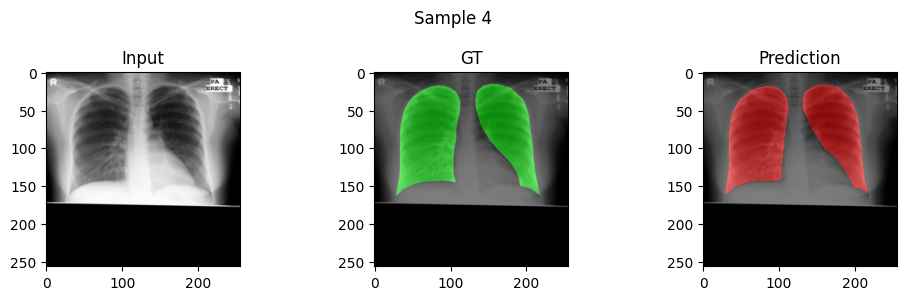

In [44]:
model.eval()
with torch.no_grad():
    for i in range(5):  # 앞의 5개만 예시로
        img = imgs[i][0].cpu().numpy()
        pred_mask = (preds[i][0].cpu().numpy() > 0.5).astype(np.float32)
        gt_mask = masks[i][0].cpu().numpy()

        overlay_pred = overlay_mask_on_image(img, pred_mask, alpha=0.5)
        overlay_gt = overlay_mask_on_image(img, gt_mask, alpha=0.5, mask_color=(0,1,0))

        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1); plt.imshow(img, cmap='gray'); plt.title("Input")
        plt.subplot(1, 3, 2); plt.imshow(overlay_gt); plt.title("GT")
        plt.subplot(1, 3, 3); plt.imshow(overlay_pred); plt.title("Prediction")
        plt.suptitle(f"Sample {i}")
        plt.tight_layout(); plt.show()
